# __Assignment 8: Logistic Regression__

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

### __1. Loading Data, Examining and Preprocessing__

In [4]:
# Loading the training data
data_raw_train = pd.read_csv('Titanic_train.csv')

# Loading the testing data
data_raw_test = pd.read_csv('Titanic_test.csv')

In [5]:
data_raw_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data_raw_train.shape

(891, 12)

In [7]:
data_raw_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
data_raw_test.shape

(418, 11)

In [9]:
data_raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Observation (Training dataset):**

- Missing/Null values are found in the columns Age, Cabin and Embarked
- We will impute values for Age (Median value) and Embarked (Mode value).
- For Cabin, the missing number is too high (77% is missing), hence it is advisable to remove this column.
- Passenger ID, Name and Ticket are passenger identifier columns and will not add value in model building, hence these columns will also be removed.

In [11]:
data_raw_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


**Observation (Test dataset):**

- Missing/Null values are found in the columns Age, Fare and Cabin
- We will impute values for Age (Median value)
- For Cabin, the missing number is too high (78% is missing), hence it is advisable to remove this column.
- 1 record in Fare column is missing, we will remove the record to avoid unnecessary computation.
- Passenger ID, Name and Ticket are passenger identifier columns and will not add value in model building, hence these columns will also be removed.

In [13]:
data_raw_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


__Preprocessing the data based on above observations__

In [15]:
# Handling Missing/ Null Values
# Age Column - Numerical
data_raw_train['Age'] = data_raw_train['Age'].fillna(data_raw_train['Age'].median())
data_raw_test['Age'] = data_raw_test['Age'].fillna(data_raw_train['Age'].median())

# Embarked Column - Categorical
data_raw_train['Embarked'] = data_raw_train['Embarked'].fillna(data_raw_train['Embarked'].mode()[0])

In [16]:
# Find records where 'Fare' is missing
data_raw_test[data_raw_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [17]:
# Dropping the unwanted record from test data, where Fare value is null
data_raw_test.dropna(subset=['Fare'], inplace=True)

In [18]:
# Dropping Non-Useful Columns
drop_cols = ["PassengerId", "Name", "Ticket", "Cabin"]
data_raw_train.drop(columns = drop_cols, axis = 1, inplace = True)
data_raw_test.drop(columns = drop_cols, axis = 1, inplace = True)

In [19]:
data_raw_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [20]:
data_raw_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


### __2. Exploratory Data Analysis (EDA)__

In [22]:
# Taking a copy of the cleaned datasets for further processing
data_train = data_raw_train.copy()
data_test = data_raw_test.copy()

In [23]:
# Identifying the numerical and categorical columns relevant to the dataset
col_num = ['Age', 'Fare']
col_cat = ['Pclass', 'SibSp', 'Parch']

__Histograms & Countplots__

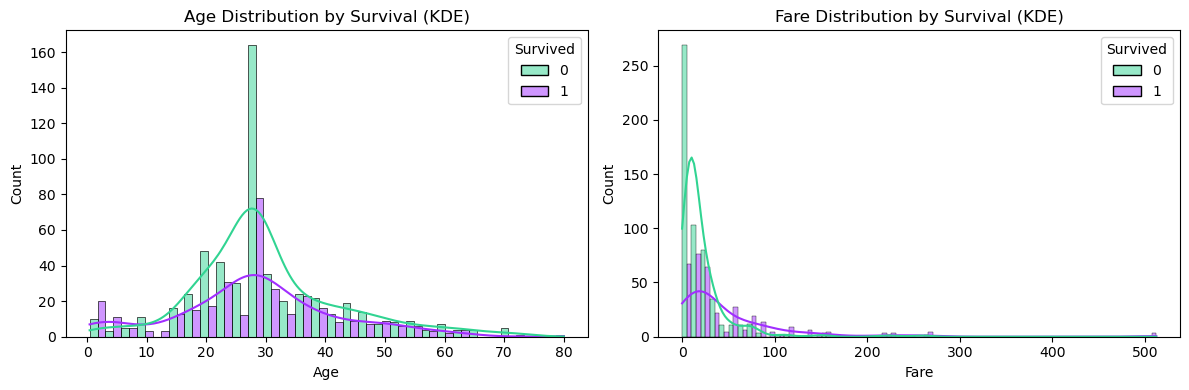

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Age distribution by survival
sns.histplot(
    data=data_train,
    x='Age',
    hue='Survived',
    multiple='dodge',
    palette=['#31D492', '#A12EFF'],
    common_norm=False,
    kde=True,
    alpha=0.5,
    ax=axes[0]
)
axes[0].set_title('Age Distribution by Survival (KDE)')
axes[0].set_xlabel('Age')

# Fare distribution by survival
sns.histplot(
    data=data_train,
    x='Fare',
    hue='Survived',
    multiple='dodge',
    binwidth=10,
    palette=['#31D492', '#A12EFF'],
    common_norm=False,
    kde=True,
    alpha=0.5,
    ax=axes[1]
)
axes[1].set_title('Fare Distribution by Survival (KDE)')
axes[1].set_xlabel('Fare')

plt.tight_layout()
plt.show()

Age distribution shows fairly normal distribution for both survived and non-survived passengers. Age alone cannot be considered as a good feature for model building due to overlaps.

Both survivor and non-survivor Fare distributions are heavily right-skewed. Most passengers paid low fares regardless of outcome.
Survivors show relatively higher density at mid and high fares. Fare provides weak-to-moderate signal alone, stronger when combined with class and sex.

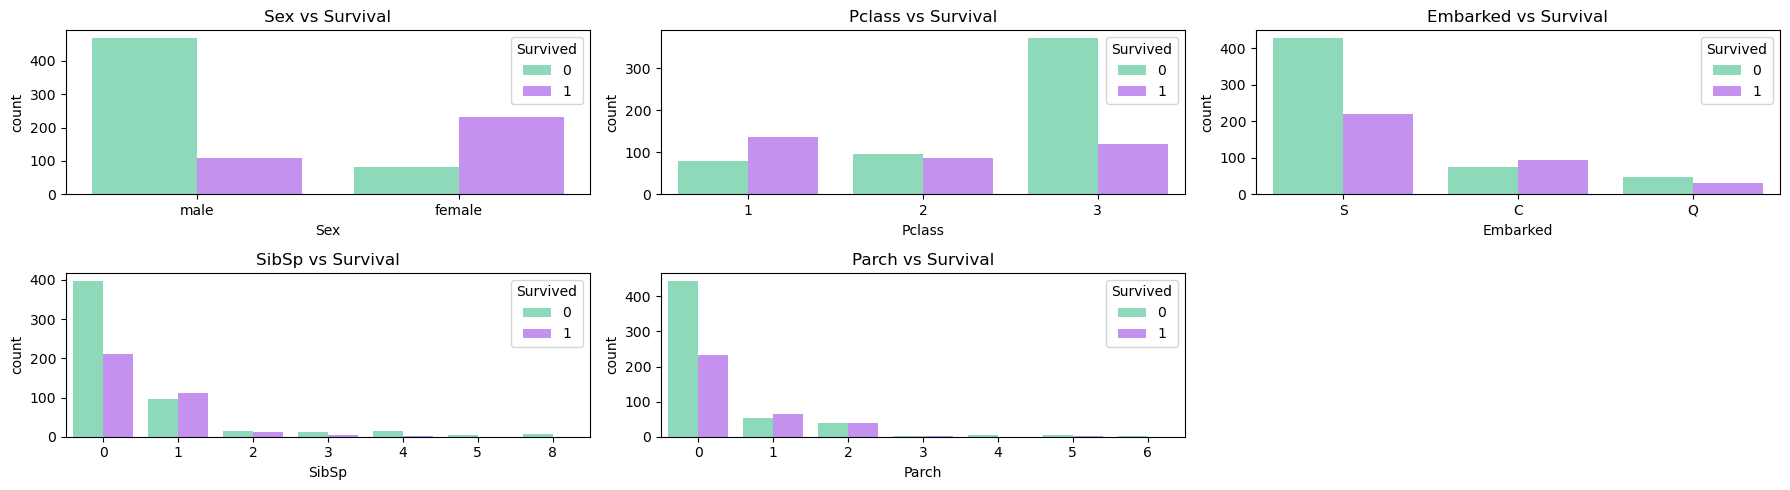

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 5))
axes = axes.flatten()

plot_cols = ['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']

for i, col in enumerate(plot_cols):
    sns.countplot(
        ax=axes[i],
        x=col,
        hue='Survived',
        data=data_train,
        palette=['#31D492', '#A12EFF'],
        alpha=0.6
    )
    axes[i].set_title(f'{col} vs Survival')

# Remove unused subplots
for j in range(len(plot_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#sns.countplot(ax=axes[0], x = "Sex", hue = "Survived", data = data_train, palette=['#31D492', '#A12EFF'], alpha = 0.5)
#axes[0].set_title("Survival by Sex")

#sns.countplot(ax=axes[1], x = "Pclass", hue = "Survived", data = data_train, palette=['#31D492', '#A12EFF'], alpha = 0.5)
#axes[1].set_title("Survival by Passenger Class")

#sns.countplot(ax=axes[2], x = "Embarked", hue = "Survived", data = data_train, palette=['#31D492', '#A12EFF'], alpha = 0.5)
#axes[2].set_title("Survival by Embarkation Port")

#sns.countplot(ax=axes[2], x = "Embarked", hue = "Survived", data = data_train, palette=['#31D492', '#A12EFF'], alpha = 0.5)
#axes[2].set_title("Survival by Embarkation Port")

#sns.countplot(ax=axes[2], x = "Embarked", hue = "Survived", data = data_train, palette=['#31D492', '#A12EFF'], alpha = 0.5)
#axes[2].set_title("Survival by Embarkation Port")

Observation: 
1. Sex v/s Survival
- Females show a higher survival probability than males.
- Indicates strong gender-based prioritization during evacuation.
- Could be a strong predictor.

2. Passenger Class (Pclass) v/s Survival
- Survival probability decreases sharply from 1st → 3rd class.
- Reflects access inequality, cabin location, and evacuation priority.
- Negative relationship with survival.

3. Embarked v/s Survival
- Passengers embarking from C have higher survival rates, while S shows the lowest survival probability.
- Moderate predictor. Collinearity to be checked

4. SibSp v/s Survival and Parch v/s Survival
- In survivors, passengers with lower family count onboard has higher chance of survival.
- However, out of non-survivors also a similar trend can be seen. Hence, other factors need to be considered along with these two features.
- Negative relationship with survival.

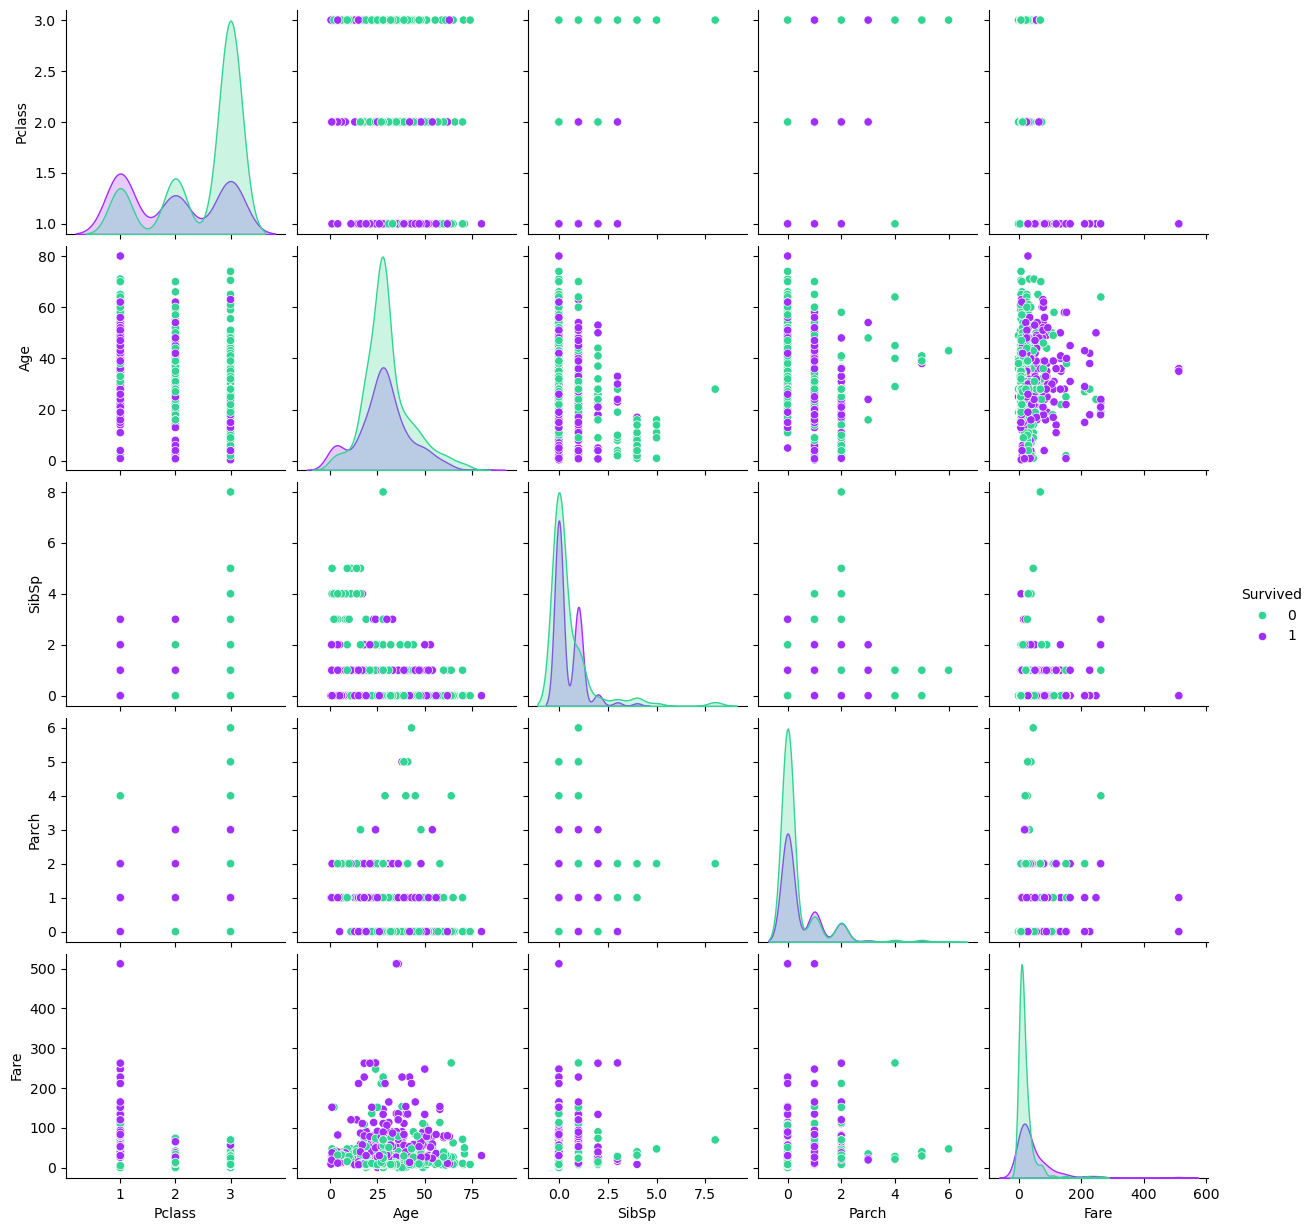

In [29]:
# Plotting the correlation between features and target
sns.pairplot (data = data_train, kind='scatter', hue = 'Survived', palette = ['#31D492', '#A12EFF'])

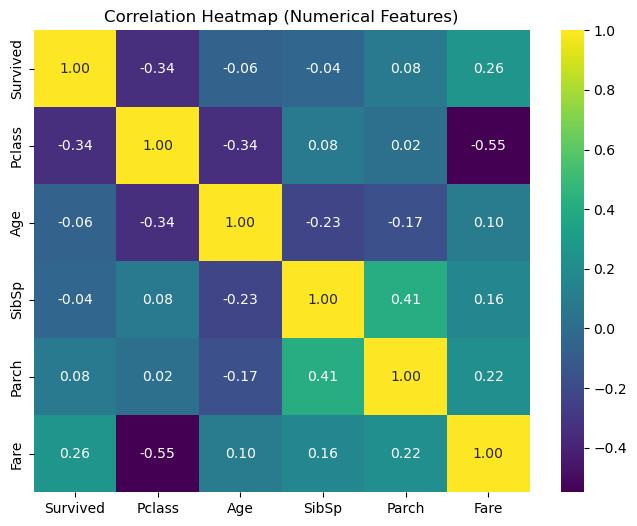

In [30]:
# Plotting a heatmap of numerical columns
num_cols = ["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]

plt.figure(figsize=(8, 6))
corr = data_train[num_cols].corr()

sns.heatmap(corr, annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

EDA Observation:

Survival on the Titanic was most strongly influenced by passenger class and fare, while age and family size showed weaker, non-linear effects.
- Passenger class (Pclass) has a clear impact on survival. People in higher classes (1st class) survived more.
- Fare is positively related to survival. Paying more generally meant better chances.
- Age has almost no linear relationship with survival. This means age matters in specific cases (like children), but not in a straight-line way.
- Family variables (SibSp, Parch) show very weak relationships with survival on their own. Family size matters only when looked at more carefully, not linearly.
- Pclass and Fare are strongly related to each other. Higher class passengers paid higher fares. This overlap should be kept in mind when interpreting the model.


### __3. Building the Logistic Regression Model__

In [33]:
# Train Test Split
X_train = data_train.drop(columns = 'Survived')
y_train = data_train['Survived']
X_test = data_test.copy()
num_cols = X_train.select_dtypes(include = ['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include = ['object']).columns.tolist()
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [34]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [35]:
# Encoding Categorical Data
X_train = pd.get_dummies(X_train, drop_first = True)
X_test = pd.get_dummies(X_test, drop_first = True)

X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True
3,1,35.0,1,0,53.1000,False,False,True
4,3,35.0,0,0,8.0500,True,False,True


In [36]:
X_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,True,True,False
1,3,47.0,1,0,7.0000,False,False,True
2,2,62.0,0,0,9.6875,True,True,False
3,3,27.0,0,0,8.6625,True,False,True
4,3,22.0,1,1,12.2875,False,False,True


In [37]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

__Model Building__

In [39]:
# Logistic Regression Model Building
log_reg = LogisticRegression(max_iter = 1000)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [40]:
y_hat = log_reg.predict(X_train_scaled)
y_hat_prob = log_reg.predict_proba(X_train_scaled)[:,1]

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       549
           1       0.76      0.70      0.73       342

    accuracy                           0.80       891
   macro avg       0.79      0.78      0.78       891
weighted avg       0.80      0.80      0.80       891



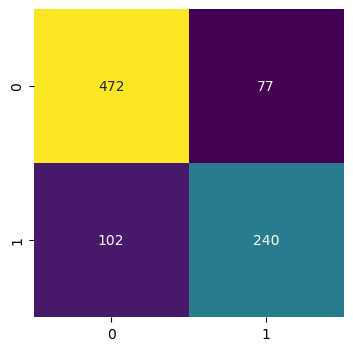

In [41]:
# Confusion Matrix and heatmap
from sklearn.metrics import confusion_matrix, classification_report

# Creating the Confusion Matrix
con_mat = confusion_matrix(y_train, y_hat)

# Plotting the Confusion Matrix
plt.figure(figsize=(4,4))
sns.heatmap(con_mat, cmap = 'viridis', annot = True, fmt = 'd', cbar=False)

print(classification_report(y_train,y_hat))
plt.show()

In [42]:
# Evaluation Metrics
print("Accuracy:", accuracy_score(y_train, y_hat))
print("Precision:", precision_score(y_train, y_hat))
print("Recall:", recall_score(y_train, y_hat))
print("F1 Score:", f1_score(y_train, y_hat))
print("ROC-AUC:", roc_auc_score(y_train, y_hat_prob))

Accuracy: 0.7991021324354658
Precision: 0.7570977917981072
Recall: 0.7017543859649122
F1 Score: 0.7283763277693475
ROC-AUC: 0.857010087452998


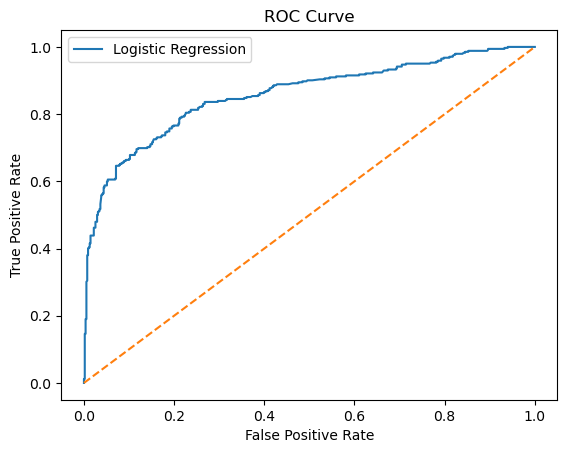

In [43]:
fpr, tpr, _ = roc_curve(y_train, y_hat_prob)

plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [44]:
# Model coefficient interpretation
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coef_df

,Feature,Coefficient
4,Fare,0.102678
6,Embarked_Q,-0.016878
3,Parch,-0.071348
7,Embarked_S,-0.180289
2,SibSp,-0.351010
1,Age,-0.497445
0,Pclass,-0.903240
5,Sex_male,-1.288314


### __5. Getting Model Ready for Deployment__

In [79]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(log_reg, f)

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model and scaler saved successfully.")

Model and scaler saved successfully.


In [81]:
import os
os.listdir()

['.ipynb_checkpoints',
 'app8.py',
 'Assignment_8.ipynb',
 'model.pkl',
 'Model_File.ipynb',
 'scaler.pkl',
 'Titanic_test.csv',
 'Titanic_train.csv']